# Delay Prediction (with Departure Delay)
---

## Project Summary at bottom + model comparisons
---


- This notebook will aim to predict the class of Arrival delay for a subset of flights from the 2006 US domestic data.
- Unlike the previous notebook, models here will allow the use of the Departure Delay feature to predict the target variable (Arrival Delay) - In theory, this should significantly improve the accuracy of the models.

In [52]:
#Importing the relevant libraries for this task 

import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score #metrics needed for the classification task
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
pd.set_option('display.max_columns', None) #making sure all columns and rows are displayed when using pandas
pd.set_option('display.max_rows', None)

### Importing Data and configuring directory
---

In [53]:
os.chdir(r"c:\\Users\\oskar\\Documents\\Projects\\Portfolio Projects")
display(os.getcwd()) # setting my working directory for this project
plane_df = pd.read_csv("pre-processed flight delay data x5000.csv", index_col=0) # importing data from previous workbook that was a part of this project.
plane_df.head()

'c:\\Users\\oskar\\Documents\\Projects\\Portfolio Projects'

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Season,CRSDepTime,CRSDepTimeMins_after_0000,CRSDepTimeFrame,CRSElapsedTime,CRSArrTime,UniqueCarrier,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,DepDelay,ArrDelay,ArrDelayClass,Date,CRSDepHour,CRSArrHour
0,CVG,CMH,116.0,1,19,6,Summer,2023-07-17 10:30:00,630,Morning,48.0,1118,OH,4,2,6,18,2,2,5.0,2.0,Slightly delayed,2006-06-19,10,11
1,ATL,SGF,563.0,7,30,7,Summer,2023-07-17 20:35:00,1235,Evening,112.0,2127,EV,5,2,7,17,2,1,153.0,136.0,Excessively delayed,2006-07-30,20,21
2,PBI,BDL,1133.0,1,31,7,Summer,2023-07-17 12:00:00,720,Afternoon,170.0,1450,DL,3,3,6,12,2,1,0.0,-4.0,On-time,2006-07-31,12,14
3,PIT,PHL,267.0,3,27,12,Winter,2023-07-17 16:50:00,1010,Afternoon,70.0,1800,US,4,4,8,19,1,1,-4.0,-11.0,On-time,2006-12-27,16,18
4,ORD,ANC,2846.0,7,23,7,Summer,2023-07-17 19:20:00,1160,Evening,399.0,2259,AS,11,3,14,12,1,2,8.0,-2.0,On-time,2006-07-23,19,22


In [54]:
arr_pred2 = plane_df[['Origin', 'Dest', 'Distance', 'DayOfWeek', 'DayofMonth', 'Month',
       'Season','CRSDepHour','CRSDepTimeFrame', 'CRSElapsedTime',"CRSArrHour" , 'UniqueCarrier', 'origin_runways',
       'destination_runways', 'total_runways', 'USair_congestion',"total_flights_origin","total_flights_destination","DepDelay", 'ArrDelay', 'ArrDelayClass']]
       
#created a new dataframe WITH dep delay + removing duplicated info such as departure and arrival times, replacing with the new departure and arrival hour.

In [55]:
arr_pred2.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Season,CRSDepHour,CRSDepTimeFrame,CRSElapsedTime,CRSArrHour,UniqueCarrier,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,DepDelay,ArrDelay,ArrDelayClass
0,CVG,CMH,116.0,1,19,6,Summer,10,Morning,48.0,11,OH,4,2,6,18,2,2,5.0,2.0,Slightly delayed
1,ATL,SGF,563.0,7,30,7,Summer,20,Evening,112.0,21,EV,5,2,7,17,2,1,153.0,136.0,Excessively delayed
2,PBI,BDL,1133.0,1,31,7,Summer,12,Afternoon,170.0,14,DL,3,3,6,12,2,1,0.0,-4.0,On-time
3,PIT,PHL,267.0,3,27,12,Winter,16,Afternoon,70.0,18,US,4,4,8,19,1,1,-4.0,-11.0,On-time
4,ORD,ANC,2846.0,7,23,7,Summer,19,Evening,399.0,22,AS,11,3,14,12,1,2,8.0,-2.0,On-time


In [56]:
#selecting the columns that I would like to be categorical type.
cat_cols = ['Origin', 'Dest', 'DayOfWeek', 'DayofMonth', 'Month', 'Season', 'CRSDepTimeFrame', 'UniqueCarrier', "CRSDepHour", "CRSArrHour", "ArrDelayClass"]

for col in arr_pred2.columns:
    if col in cat_cols:
        arr_pred2.loc[:, col] = arr_pred2[col].astype("category") #transforming into categorcal using loc

arr_pred2 = arr_pred2.drop("CRSElapsedTime", axis=1)

C:\Users\oskar\AppData\Local\Temp\ipykernel_29620\1865699566.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr_pred2.loc[:, col] = arr_pred2[col].astype("category")
C:\Users\oskar\AppData\Local\Temp\ipykernel_29620\1865699566.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr_pred2.loc[:, col] = arr_pred2[col].astype("category")
C:\Users\oskar\AppData\Local\Temp\ipykernel_29620\1865699566.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [57]:
#Selecting the features and target.
X = arr_pred2.drop(["ArrDelay", "ArrDelayClass"], axis=1) 
y = arr_pred2["ArrDelayClass"] #selecting the target

display(X.head(), y.head())

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Season,CRSDepHour,CRSDepTimeFrame,CRSArrHour,UniqueCarrier,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,DepDelay
0,CVG,CMH,116.0,1,19,6,Summer,10,Morning,11,OH,4,2,6,18,2,2,5.0
1,ATL,SGF,563.0,7,30,7,Summer,20,Evening,21,EV,5,2,7,17,2,1,153.0
2,PBI,BDL,1133.0,1,31,7,Summer,12,Afternoon,14,DL,3,3,6,12,2,1,0.0
3,PIT,PHL,267.0,3,27,12,Winter,16,Afternoon,18,US,4,4,8,19,1,1,-4.0
4,ORD,ANC,2846.0,7,23,7,Summer,19,Evening,22,AS,11,3,14,12,1,2,8.0


0       Slightly delayed
1    Excessively delayed
2                On-time
3                On-time
4                On-time
Name: ArrDelayClass, dtype: category
Categories (4, object): ['Excessively delayed', 'Moderately delayed', 'On-time', 'Slightly delayed']

- Here we will observe the distribution of numeric data, so that we know which need to be transformed to better suit the ML models

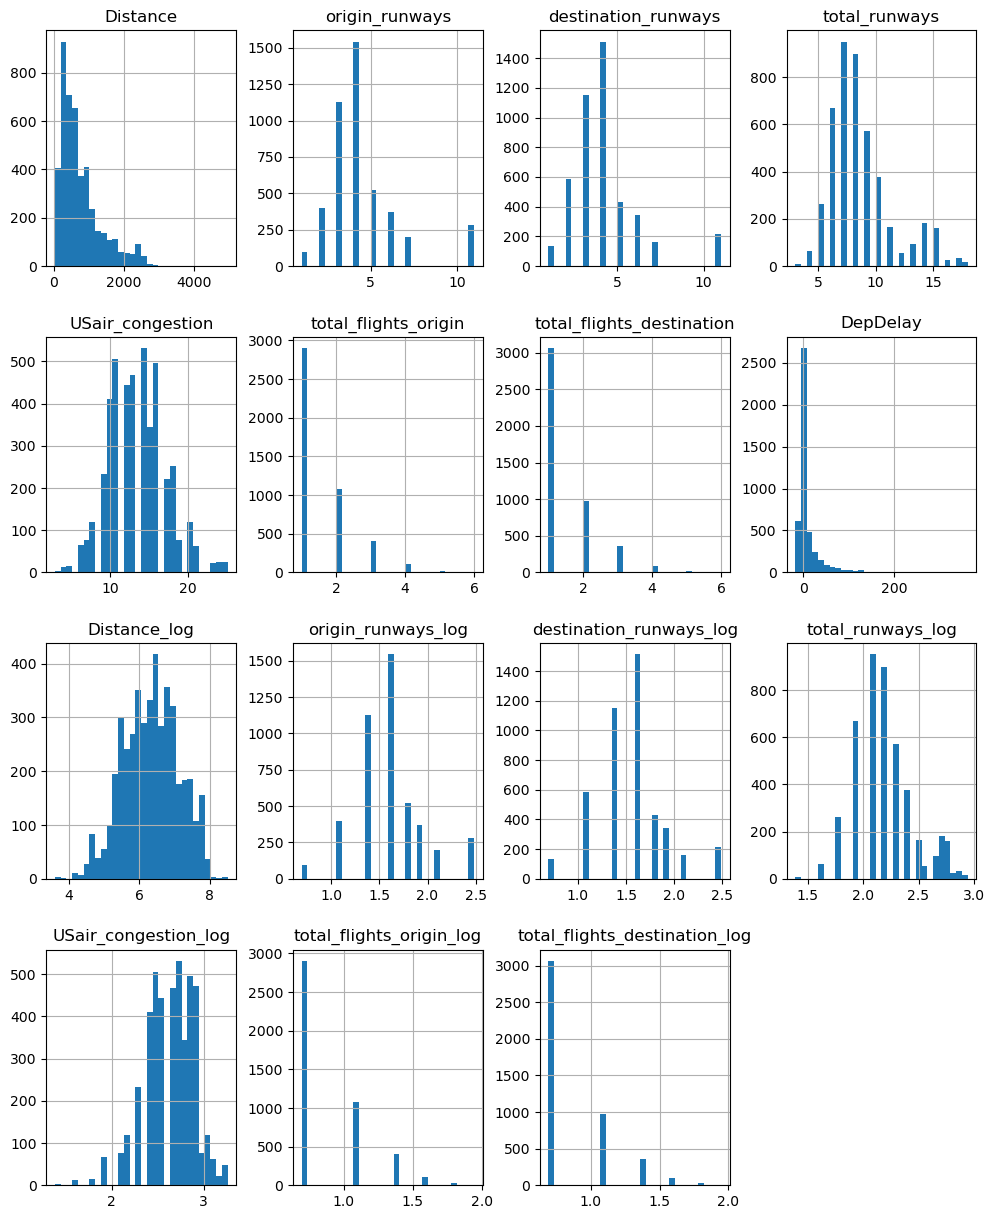

Distance                         1.560509
origin_runways                   1.740667
destination_runways              1.807815
total_runways                    1.178276
USair_congestion                 0.325622
total_flights_origin             1.795971
total_flights_destination        1.965427
DepDelay                         4.567907
Distance_log                    -0.122303
origin_runways_log               0.415248
destination_runways_log          0.336391
total_runways_log                0.455226
USair_congestion_log            -0.553993
total_flights_origin_log         1.200941
total_flights_destination_log    1.362923
dtype: float64


In [58]:
skewed_cols = ["Distance", "origin_runways", "destination_runways", "total_runways", "USair_congestion","total_flights_origin","total_flights_destination"]

for col in skewed_cols:
    X[col + "_log"] = np.log1p(X[col]) #np.log1p() can be transformed before or after splitting into train and test sets - it doesnt "leak"

X.hist(bins=30, figsize=(12,15))
plt.show()

skew = X.skew()
print(skew)

- Following the transformations, some of the histograms look more normally distributed.

### Assess the Departure Delay Feature
---

count    4532.000000
mean       10.002648
std        32.140053
min       -18.000000
25%        -4.000000
50%         0.000000
75%         9.000000
max       361.000000
Name: DepDelay, dtype: float64

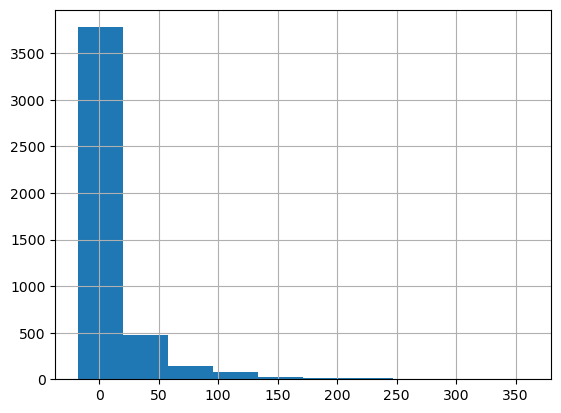

In [59]:
X["DepDelay"].hist()
X["DepDelay"].describe()

- The mean departure delay was 10 minutes. The maximum was 361 and the minimum was a flight that left 18 minutes early.

In [68]:
X.dtypes

Origin                           category
Dest                             category
DayOfWeek                        category
DayofMonth                       category
Month                            category
Season                           category
CRSDepHour                       category
CRSDepTimeFrame                  category
CRSArrHour                       category
UniqueCarrier                    category
DepDelay                          float64
Distance_log                      float64
origin_runways_log                float64
destination_runways_log           float64
total_runways_log                 float64
USair_congestion_log              float64
total_flights_origin_log          float64
total_flights_destination_log     float64
dtype: object

In [60]:
X.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Season,CRSDepHour,CRSDepTimeFrame,CRSArrHour,UniqueCarrier,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,DepDelay,Distance_log,origin_runways_log,destination_runways_log,total_runways_log,USair_congestion_log,total_flights_origin_log,total_flights_destination_log
0,CVG,CMH,116.0,1,19,6,Summer,10,Morning,11,OH,4,2,6,18,2,2,5.0,4.762174,1.609438,1.098612,1.945910,2.944439,1.098612,1.098612
1,ATL,SGF,563.0,7,30,7,Summer,20,Evening,21,EV,5,2,7,17,2,1,153.0,6.335054,1.791759,1.098612,2.079442,2.890372,1.098612,0.693147
2,PBI,BDL,1133.0,1,31,7,Summer,12,Afternoon,14,DL,3,3,6,12,2,1,0.0,7.033506,1.386294,1.386294,1.945910,2.564949,1.098612,0.693147
3,PIT,PHL,267.0,3,27,12,Winter,16,Afternoon,18,US,4,4,8,19,1,1,-4.0,5.590987,1.609438,1.609438,2.197225,2.995732,0.693147,0.693147
4,ORD,ANC,2846.0,7,23,7,Summer,19,Evening,22,AS,11,3,14,12,1,2,8.0,7.954021,2.484907,1.386294,2.708050,2.564949,0.693147,1.098612


### Dropping the now transformed columns
---
- Now that we have transformed non-normal columns so they are normally distributed, we can remove the originals to reduce bias/duplication effects.

In [61]:
original_cols_drop = ["Distance", "origin_runways", "destination_runways", "total_runways","USair_congestion","total_flights_origin","total_flights_destination"] # dropping these columns as would be duplicate info and for bias the importance in models if kept in.
X = X.drop(original_cols_drop, axis=1)

In [73]:
X = pd.get_dummies(X)
X.head() # creating dummy variables for categorical variables in X

,DepDelay,Distance_log,origin_runways_log,destination_runways_log,total_runways_log,USair_congestion_log,total_flights_origin_log,total_flights_destination_log,Origin_ABQ,Origin_ALB,Origin_ANC,Origin_ATL,Origin_AUS,Origin_BDL,Origin_BHM,Origin_BNA,Origin_BOI,Origin_BOS,Origin_BTR,Origin_BUF,Origin_BUR,Origin_BWI,Origin_CAK,Origin_CLE,Origin_CLT,Origin_CMH,Origin_COS,Origin_CVG,Origin_DAL,Origin_DAY,Origin_DCA,Origin_DEN,Origin_DFW,Origin_DSM,Origin_DTW,Origin_ELP,Origin_EWR,Origin_FAT,Origin_FLL,Origin_GPT,Origin_GRR,Origin_GSO,Origin_GSP,Origin_HNL,Origin_HOU,Origin_IAD,Origin_IAH,Origin_ICT,Origin_IND,Origin_ISP,Origin_JAX,Origin_JFK,Origin_LAS,Origin_LAX,Origin_LBB,Origin_LGA,Origin_LGB,Origin_LIH,Origin_LIT,Origin_MCI,Origin_MCO,Origin_MDW,Origin_MEM,Origin_MHT,Origin_MIA,Origin_MKE,Origin_MRY,Origin_MSN,Origin_MSP,Origin_MSY,Origin_OAK,Origin_OGG,Origin_OKC,Origin_OMA,Origin_ONT,Origin_ORD,Origin_ORF,Origin_PBI,Origin_PDX,Origin_PHF,Origin_PHL,Origin_PHX,Origin_PIT,Origin_PNS,Origin_PVD,Origin_RDU,Origin_RIC,Origin_RNO,Origin_ROC,Origin_RSW,Origin_SAN,Origin_SAT,Origin_SAV,Origin_SBA,Origin_SDF,Origin_SEA,Origin_SFO,Origin_SHV,Origin_SJC,Origin_SJU,Origin_SLC,Origin_SMF,Origin_SNA,Origin_STL,Origin_TPA,Origin_TUL,Origin_TUS,Origin_TYS,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ACK,Dest_ACT,Dest_ACV,Dest_AEX,Dest_AGS,Dest_ALB,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BFL,Dest_BGM,Dest_BGR,Dest_BHM,Dest_BIL,Dest_BIS,Dest_BMI,Dest_BNA,Dest_BOI,Dest_BOS,Dest_BRO,Dest_BTM,Dest_BTR,Dest_BTV,Dest_BUF,Dest_BUR,Dest_BWI,Dest_BZN,Dest_CAE,Dest_CAK,Dest_CHA,Dest_CHO,Dest_CHS,Dest_CIC,Dest_CID,Dest_CLD,Dest_CLE,Dest_CLT,Dest_CMH,Dest_CMI,Dest_COD,Dest_COS,Dest_CPR,Dest_CRP,Dest_CRW,Dest_CVG,Dest_DAB,Dest_DAL,Dest_DAY,Dest_DBQ,Dest_DCA,Dest_DEN,Dest_DFW,Dest_DRO,Dest_DSM,Dest_DTW,Dest_EGE,Dest_EKO,Dest_ELP,Dest_ERI,Dest_EUG,Dest_EVV,Dest_EWR,Dest_FAI,Dest_FAR,Dest_FAT,Dest_FAY,Dest_FCA,Dest_FLL,Dest_FLO,Dest_FNT,Dest_FSD,Dest_FSM,Dest_FWA,Dest_GEG,Dest_GFK,Dest_GGG,Dest_GJT,Dest_GPT,Dest_GRB,Dest_GRK,Dest_GRR,Dest_GSO,Dest_GSP,Dest_GTF,Dest_GTR,Dest_GUC,Dest_HDN,Dest_HLN,Dest_HNL,Dest_HOU,Dest_HPN,Dest_HRL,Dest_HSV,Dest_IAD,Dest_IAH,Dest_ICT,Dest_IDA,Dest_ILM,Dest_IND,Dest_ISO,Dest_ISP,Dest_ITO,Dest_JAC,Dest_JAN,Dest_JAX,Dest_JFK,Dest_KOA,Dest_LAN,Dest_LAS,Dest_LAX,Dest_LBB,Dest_LCH,Dest_LEX,Dest_LFT,Dest_LGA,Dest_LGB,Dest_LIH,Dest_LIT,Dest_LNK,Dest_LRD,Dest_LSE,Dest_MAF,Dest_MBS,Dest_MCI,Dest_MCN,Dest_MCO,Dest_MDT,Dest_MDW,Dest_MEM,Dest_MFE,Dest_MFR,Dest_MHT,Dest_MIA,Dest_MKE,Dest_MLB,Dest_MLI,Dest_MOB,Dest_MOD,Dest_MOT,Dest_MRY,Dest_MSN,Dest_MSO,Dest_MSP,Dest_MSY,Dest_MYR,Dest_OAK,Dest_OGG,Dest_OKC,Dest_OMA,Dest_ONT,Dest_ORD,Dest_ORF,Dest_OXR,Dest_PBI,Dest_PDX,Dest_PFN,Dest_PHF,Dest_PHL,Dest_PHX,Dest_PIA,Dest_PIH,Dest_PIT,Dest_PNS,Dest_PSC,Dest_PSE,Dest_PSP,Dest_PVD,Dest_PWM,Dest_RAP,Dest_RDD,Dest_RDM,Dest_RDU,Dest_RIC,Dest_RNO,Dest_ROA,Dest_ROC,Dest_RST,Dest_RSW,Dest_SAN,Dest_SAT,Dest_SAV,Dest_SBA,Dest_SBP,Dest_SDF,Dest_SEA,Dest_SFO,Dest_SGF,Dest_SGU,Dest_SHV,Dest_SJC,Dest_SJT,Dest_SJU,Dest_SLC,Dest_SMF,Dest_SMX,Dest_SNA,Dest_SPI,Dest_SPS,Dest_SRQ,Dest_STL,Dest_STT,Dest_SUN,Dest_SWF,Dest_SYR,Dest_TLH,Dest_TOL,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TYS,Dest_VPS,Dest_XNA,Dest_YUM,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,DayofMonth_1,DayofMonth_2,DayofMonth_3,DayofMonth_4,DayofMonth_5,DayofMonth_6,DayofMonth_7,DayofMonth_8,DayofMonth_9,DayofMonth_10,DayofMonth_11,DayofMonth_12,DayofMonth_13,DayofMonth_14,DayofMonth_15,DayofMonth_16,DayofMonth_17,DayofMonth_18,DayofMonth_19,DayofMonth_20,DayofMonth_21,DayofMonth_22,DayofMonth_23,DayofMonth_24,DayofMonth_25,DayofMonth_26,DayofMonth_27,DayofMonth_28,DayofMonth_29,DayofMonth_30,DayofMonth_31,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,CRSDepHour_0,CRSDepHour_1,CRSDepHour_2,CRS

## Splitting + Standardizing 

In [74]:
display(y.value_counts())
# Initial data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18, stratify=y) # Splitting into train test split. stratify=y to maintain the class proportions in train and tests sets.

# Scaling process
scaler = StandardScaler() #initiating the scaler

cols_to_scale = ['Distance_log', 'origin_runways_log', 'destination_runways_log', 'total_runways_log','USair_congestion_log','total_flights_origin_log','total_flights_destination_log',"DepDelay"] #these columns to be on same scale to precent biasing in distance orientated models.

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()   #making clean copies of training data that can be used below.

# Applying scaler
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale]) #only transforming on the test data to prevent data leakage.

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train_scaled, y_train) #Using SMOTE to resample by generating similar samples of the minority classes.
X_test = X_test_scaled

On-time                2478
Slightly delayed       1066
Moderately delayed      679
Excessively delayed     309
Name: ArrDelayClass, dtype: int64

In [75]:
X.head()

,DepDelay,Distance_log,origin_runways_log,destination_runways_log,total_runways_log,USair_congestion_log,total_flights_origin_log,total_flights_destination_log,Origin_ABQ,Origin_ALB,Origin_ANC,Origin_ATL,Origin_AUS,Origin_BDL,Origin_BHM,Origin_BNA,Origin_BOI,Origin_BOS,Origin_BTR,Origin_BUF,Origin_BUR,Origin_BWI,Origin_CAK,Origin_CLE,Origin_CLT,Origin_CMH,Origin_COS,Origin_CVG,Origin_DAL,Origin_DAY,Origin_DCA,Origin_DEN,Origin_DFW,Origin_DSM,Origin_DTW,Origin_ELP,Origin_EWR,Origin_FAT,Origin_FLL,Origin_GPT,Origin_GRR,Origin_GSO,Origin_GSP,Origin_HNL,Origin_HOU,Origin_IAD,Origin_IAH,Origin_ICT,Origin_IND,Origin_ISP,Origin_JAX,Origin_JFK,Origin_LAS,Origin_LAX,Origin_LBB,Origin_LGA,Origin_LGB,Origin_LIH,Origin_LIT,Origin_MCI,Origin_MCO,Origin_MDW,Origin_MEM,Origin_MHT,Origin_MIA,Origin_MKE,Origin_MRY,Origin_MSN,Origin_MSP,Origin_MSY,Origin_OAK,Origin_OGG,Origin_OKC,Origin_OMA,Origin_ONT,Origin_ORD,Origin_ORF,Origin_PBI,Origin_PDX,Origin_PHF,Origin_PHL,Origin_PHX,Origin_PIT,Origin_PNS,Origin_PVD,Origin_RDU,Origin_RIC,Origin_RNO,Origin_ROC,Origin_RSW,Origin_SAN,Origin_SAT,Origin_SAV,Origin_SBA,Origin_SDF,Origin_SEA,Origin_SFO,Origin_SHV,Origin_SJC,Origin_SJU,Origin_SLC,Origin_SMF,Origin_SNA,Origin_STL,Origin_TPA,Origin_TUL,Origin_TUS,Origin_TYS,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ACK,Dest_ACT,Dest_ACV,Dest_AEX,Dest_AGS,Dest_ALB,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BFL,Dest_BGM,Dest_BGR,Dest_BHM,Dest_BIL,Dest_BIS,Dest_BMI,Dest_BNA,Dest_BOI,Dest_BOS,Dest_BRO,Dest_BTM,Dest_BTR,Dest_BTV,Dest_BUF,Dest_BUR,Dest_BWI,Dest_BZN,Dest_CAE,Dest_CAK,Dest_CHA,Dest_CHO,Dest_CHS,Dest_CIC,Dest_CID,Dest_CLD,Dest_CLE,Dest_CLT,Dest_CMH,Dest_CMI,Dest_COD,Dest_COS,Dest_CPR,Dest_CRP,Dest_CRW,Dest_CVG,Dest_DAB,Dest_DAL,Dest_DAY,Dest_DBQ,Dest_DCA,Dest_DEN,Dest_DFW,Dest_DRO,Dest_DSM,Dest_DTW,Dest_EGE,Dest_EKO,Dest_ELP,Dest_ERI,Dest_EUG,Dest_EVV,Dest_EWR,Dest_FAI,Dest_FAR,Dest_FAT,Dest_FAY,Dest_FCA,Dest_FLL,Dest_FLO,Dest_FNT,Dest_FSD,Dest_FSM,Dest_FWA,Dest_GEG,Dest_GFK,Dest_GGG,Dest_GJT,Dest_GPT,Dest_GRB,Dest_GRK,Dest_GRR,Dest_GSO,Dest_GSP,Dest_GTF,Dest_GTR,Dest_GUC,Dest_HDN,Dest_HLN,Dest_HNL,Dest_HOU,Dest_HPN,Dest_HRL,Dest_HSV,Dest_IAD,Dest_IAH,Dest_ICT,Dest_IDA,Dest_ILM,Dest_IND,Dest_ISO,Dest_ISP,Dest_ITO,Dest_JAC,Dest_JAN,Dest_JAX,Dest_JFK,Dest_KOA,Dest_LAN,Dest_LAS,Dest_LAX,Dest_LBB,Dest_LCH,Dest_LEX,Dest_LFT,Dest_LGA,Dest_LGB,Dest_LIH,Dest_LIT,Dest_LNK,Dest_LRD,Dest_LSE,Dest_MAF,Dest_MBS,Dest_MCI,Dest_MCN,Dest_MCO,Dest_MDT,Dest_MDW,Dest_MEM,Dest_MFE,Dest_MFR,Dest_MHT,Dest_MIA,Dest_MKE,Dest_MLB,Dest_MLI,Dest_MOB,Dest_MOD,Dest_MOT,Dest_MRY,Dest_MSN,Dest_MSO,Dest_MSP,Dest_MSY,Dest_MYR,Dest_OAK,Dest_OGG,Dest_OKC,Dest_OMA,Dest_ONT,Dest_ORD,Dest_ORF,Dest_OXR,Dest_PBI,Dest_PDX,Dest_PFN,Dest_PHF,Dest_PHL,Dest_PHX,Dest_PIA,Dest_PIH,Dest_PIT,Dest_PNS,Dest_PSC,Dest_PSE,Dest_PSP,Dest_PVD,Dest_PWM,Dest_RAP,Dest_RDD,Dest_RDM,Dest_RDU,Dest_RIC,Dest_RNO,Dest_ROA,Dest_ROC,Dest_RST,Dest_RSW,Dest_SAN,Dest_SAT,Dest_SAV,Dest_SBA,Dest_SBP,Dest_SDF,Dest_SEA,Dest_SFO,Dest_SGF,Dest_SGU,Dest_SHV,Dest_SJC,Dest_SJT,Dest_SJU,Dest_SLC,Dest_SMF,Dest_SMX,Dest_SNA,Dest_SPI,Dest_SPS,Dest_SRQ,Dest_STL,Dest_STT,Dest_SUN,Dest_SWF,Dest_SYR,Dest_TLH,Dest_TOL,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TYS,Dest_VPS,Dest_XNA,Dest_YUM,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,DayofMonth_1,DayofMonth_2,DayofMonth_3,DayofMonth_4,DayofMonth_5,DayofMonth_6,DayofMonth_7,DayofMonth_8,DayofMonth_9,DayofMonth_10,DayofMonth_11,DayofMonth_12,DayofMonth_13,DayofMonth_14,DayofMonth_15,DayofMonth_16,DayofMonth_17,DayofMonth_18,DayofMonth_19,DayofMonth_20,DayofMonth_21,DayofMonth_22,DayofMonth_23,DayofMonth_24,DayofMonth_25,DayofMonth_26,DayofMonth_27,DayofMonth_28,DayofMonth_29,DayofMonth_30,DayofMonth_31,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,CRSDepHour_0,CRSDepHour_1,CRSDepHour_2,CRS

### Data Checks before ML

In [76]:
display(X_train.head(2))
display(X_test.head(2))
display(y_train.value_counts(normalize=True)) #results show SMOTE worked - each class has proportions of 0.25
display(y_test.value_counts(normalize=True))

,DepDelay,Distance_log,origin_runways_log,destination_runways_log,total_runways_log,USair_congestion_log,total_flights_origin_log,total_flights_destination_log,Origin_ABQ,Origin_ALB,Origin_ANC,Origin_ATL,Origin_AUS,Origin_BDL,Origin_BHM,Origin_BNA,Origin_BOI,Origin_BOS,Origin_BTR,Origin_BUF,Origin_BUR,Origin_BWI,Origin_CAK,Origin_CLE,Origin_CLT,Origin_CMH,Origin_COS,Origin_CVG,Origin_DAL,Origin_DAY,Origin_DCA,Origin_DEN,Origin_DFW,Origin_DSM,Origin_DTW,Origin_ELP,Origin_EWR,Origin_FAT,Origin_FLL,Origin_GPT,Origin_GRR,Origin_GSO,Origin_GSP,Origin_HNL,Origin_HOU,Origin_IAD,Origin_IAH,Origin_ICT,Origin_IND,Origin_ISP,Origin_JAX,Origin_JFK,Origin_LAS,Origin_LAX,Origin_LBB,Origin_LGA,Origin_LGB,Origin_LIH,Origin_LIT,Origin_MCI,Origin_MCO,Origin_MDW,Origin_MEM,Origin_MHT,Origin_MIA,Origin_MKE,Origin_MRY,Origin_MSN,Origin_MSP,Origin_MSY,Origin_OAK,Origin_OGG,Origin_OKC,Origin_OMA,Origin_ONT,Origin_ORD,Origin_ORF,Origin_PBI,Origin_PDX,Origin_PHF,Origin_PHL,Origin_PHX,Origin_PIT,Origin_PNS,Origin_PVD,Origin_RDU,Origin_RIC,Origin_RNO,Origin_ROC,Origin_RSW,Origin_SAN,Origin_SAT,Origin_SAV,Origin_SBA,Origin_SDF,Origin_SEA,Origin_SFO,Origin_SHV,Origin_SJC,Origin_SJU,Origin_SLC,Origin_SMF,Origin_SNA,Origin_STL,Origin_TPA,Origin_TUL,Origin_TUS,Origin_TYS,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ACK,Dest_ACT,Dest_ACV,Dest_AEX,Dest_AGS,Dest_ALB,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BFL,Dest_BGM,Dest_BGR,Dest_BHM,Dest_BIL,Dest_BIS,Dest_BMI,Dest_BNA,Dest_BOI,Dest_BOS,Dest_BRO,Dest_BTM,Dest_BTR,Dest_BTV,Dest_BUF,Dest_BUR,Dest_BWI,Dest_BZN,Dest_CAE,Dest_CAK,Dest_CHA,Dest_CHO,Dest_CHS,Dest_CIC,Dest_CID,Dest_CLD,Dest_CLE,Dest_CLT,Dest_CMH,Dest_CMI,Dest_COD,Dest_COS,Dest_CPR,Dest_CRP,Dest_CRW,Dest_CVG,Dest_DAB,Dest_DAL,Dest_DAY,Dest_DBQ,Dest_DCA,Dest_DEN,Dest_DFW,Dest_DRO,Dest_DSM,Dest_DTW,Dest_EGE,Dest_EKO,Dest_ELP,Dest_ERI,Dest_EUG,Dest_EVV,Dest_EWR,Dest_FAI,Dest_FAR,Dest_FAT,Dest_FAY,Dest_FCA,Dest_FLL,Dest_FLO,Dest_FNT,Dest_FSD,Dest_FSM,Dest_FWA,Dest_GEG,Dest_GFK,Dest_GGG,Dest_GJT,Dest_GPT,Dest_GRB,Dest_GRK,Dest_GRR,Dest_GSO,Dest_GSP,Dest_GTF,Dest_GTR,Dest_GUC,Dest_HDN,Dest_HLN,Dest_HNL,Dest_HOU,Dest_HPN,Dest_HRL,Dest_HSV,Dest_IAD,Dest_IAH,Dest_ICT,Dest_IDA,Dest_ILM,Dest_IND,Dest_ISO,Dest_ISP,Dest_ITO,Dest_JAC,Dest_JAN,Dest_JAX,Dest_JFK,Dest_KOA,Dest_LAN,Dest_LAS,Dest_LAX,Dest_LBB,Dest_LCH,Dest_LEX,Dest_LFT,Dest_LGA,Dest_LGB,Dest_LIH,Dest_LIT,Dest_LNK,Dest_LRD,Dest_LSE,Dest_MAF,Dest_MBS,Dest_MCI,Dest_MCN,Dest_MCO,Dest_MDT,Dest_MDW,Dest_MEM,Dest_MFE,Dest_MFR,Dest_MHT,Dest_MIA,Dest_MKE,Dest_MLB,Dest_MLI,Dest_MOB,Dest_MOD,Dest_MOT,Dest_MRY,Dest_MSN,Dest_MSO,Dest_MSP,Dest_MSY,Dest_MYR,Dest_OAK,Dest_OGG,Dest_OKC,Dest_OMA,Dest_ONT,Dest_ORD,Dest_ORF,Dest_OXR,Dest_PBI,Dest_PDX,Dest_PFN,Dest_PHF,Dest_PHL,Dest_PHX,Dest_PIA,Dest_PIH,Dest_PIT,Dest_PNS,Dest_PSC,Dest_PSE,Dest_PSP,Dest_PVD,Dest_PWM,Dest_RAP,Dest_RDD,Dest_RDM,Dest_RDU,Dest_RIC,Dest_RNO,Dest_ROA,Dest_ROC,Dest_RST,Dest_RSW,Dest_SAN,Dest_SAT,Dest_SAV,Dest_SBA,Dest_SBP,Dest_SDF,Dest_SEA,Dest_SFO,Dest_SGF,Dest_SGU,Dest_SHV,Dest_SJC,Dest_SJT,Dest_SJU,Dest_SLC,Dest_SMF,Dest_SMX,Dest_SNA,Dest_SPI,Dest_SPS,Dest_SRQ,Dest_STL,Dest_STT,Dest_SUN,Dest_SWF,Dest_SYR,Dest_TLH,Dest_TOL,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TYS,Dest_VPS,Dest_XNA,Dest_YUM,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,DayofMonth_1,DayofMonth_2,DayofMonth_3,DayofMonth_4,DayofMonth_5,DayofMonth_6,DayofMonth_7,DayofMonth_8,DayofMonth_9,DayofMonth_10,DayofMonth_11,DayofMonth_12,DayofMonth_13,DayofMonth_14,DayofMonth_15,DayofMonth_16,DayofMonth_17,DayofMonth_18,DayofMonth_19,DayofMonth_20,DayofMonth_21,DayofMonth_22,DayofMonth_23,DayofMonth_24,DayofMonth_25,DayofMonth_26,DayofMonth_27,DayofMonth_28,DayofMonth_29,DayofMonth_30,DayofMonth_31,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,CRSDepHour_0,CRSDepHour_1,CRSDepHour_2,CRS

,DepDelay,Distance_log,origin_runways_log,destination_runways_log,total_runways_log,USair_congestion_log,total_flights_origin_log,total_flights_destination_log,Origin_ABQ,Origin_ALB,Origin_ANC,Origin_ATL,Origin_AUS,Origin_BDL,Origin_BHM,Origin_BNA,Origin_BOI,Origin_BOS,Origin_BTR,Origin_BUF,Origin_BUR,Origin_BWI,Origin_CAK,Origin_CLE,Origin_CLT,Origin_CMH,Origin_COS,Origin_CVG,Origin_DAL,Origin_DAY,Origin_DCA,Origin_DEN,Origin_DFW,Origin_DSM,Origin_DTW,Origin_ELP,Origin_EWR,Origin_FAT,Origin_FLL,Origin_GPT,Origin_GRR,Origin_GSO,Origin_GSP,Origin_HNL,Origin_HOU,Origin_IAD,Origin_IAH,Origin_ICT,Origin_IND,Origin_ISP,Origin_JAX,Origin_JFK,Origin_LAS,Origin_LAX,Origin_LBB,Origin_LGA,Origin_LGB,Origin_LIH,Origin_LIT,Origin_MCI,Origin_MCO,Origin_MDW,Origin_MEM,Origin_MHT,Origin_MIA,Origin_MKE,Origin_MRY,Origin_MSN,Origin_MSP,Origin_MSY,Origin_OAK,Origin_OGG,Origin_OKC,Origin_OMA,Origin_ONT,Origin_ORD,Origin_ORF,Origin_PBI,Origin_PDX,Origin_PHF,Origin_PHL,Origin_PHX,Origin_PIT,Origin_PNS,Origin_PVD,Origin_RDU,Origin_RIC,Origin_RNO,Origin_ROC,Origin_RSW,Origin_SAN,Origin_SAT,Origin_SAV,Origin_SBA,Origin_SDF,Origin_SEA,Origin_SFO,Origin_SHV,Origin_SJC,Origin_SJU,Origin_SLC,Origin_SMF,Origin_SNA,Origin_STL,Origin_TPA,Origin_TUL,Origin_TUS,Origin_TYS,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ACK,Dest_ACT,Dest_ACV,Dest_AEX,Dest_AGS,Dest_ALB,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BFL,Dest_BGM,Dest_BGR,Dest_BHM,Dest_BIL,Dest_BIS,Dest_BMI,Dest_BNA,Dest_BOI,Dest_BOS,Dest_BRO,Dest_BTM,Dest_BTR,Dest_BTV,Dest_BUF,Dest_BUR,Dest_BWI,Dest_BZN,Dest_CAE,Dest_CAK,Dest_CHA,Dest_CHO,Dest_CHS,Dest_CIC,Dest_CID,Dest_CLD,Dest_CLE,Dest_CLT,Dest_CMH,Dest_CMI,Dest_COD,Dest_COS,Dest_CPR,Dest_CRP,Dest_CRW,Dest_CVG,Dest_DAB,Dest_DAL,Dest_DAY,Dest_DBQ,Dest_DCA,Dest_DEN,Dest_DFW,Dest_DRO,Dest_DSM,Dest_DTW,Dest_EGE,Dest_EKO,Dest_ELP,Dest_ERI,Dest_EUG,Dest_EVV,Dest_EWR,Dest_FAI,Dest_FAR,Dest_FAT,Dest_FAY,Dest_FCA,Dest_FLL,Dest_FLO,Dest_FNT,Dest_FSD,Dest_FSM,Dest_FWA,Dest_GEG,Dest_GFK,Dest_GGG,Dest_GJT,Dest_GPT,Dest_GRB,Dest_GRK,Dest_GRR,Dest_GSO,Dest_GSP,Dest_GTF,Dest_GTR,Dest_GUC,Dest_HDN,Dest_HLN,Dest_HNL,Dest_HOU,Dest_HPN,Dest_HRL,Dest_HSV,Dest_IAD,Dest_IAH,Dest_ICT,Dest_IDA,Dest_ILM,Dest_IND,Dest_ISO,Dest_ISP,Dest_ITO,Dest_JAC,Dest_JAN,Dest_JAX,Dest_JFK,Dest_KOA,Dest_LAN,Dest_LAS,Dest_LAX,Dest_LBB,Dest_LCH,Dest_LEX,Dest_LFT,Dest_LGA,Dest_LGB,Dest_LIH,Dest_LIT,Dest_LNK,Dest_LRD,Dest_LSE,Dest_MAF,Dest_MBS,Dest_MCI,Dest_MCN,Dest_MCO,Dest_MDT,Dest_MDW,Dest_MEM,Dest_MFE,Dest_MFR,Dest_MHT,Dest_MIA,Dest_MKE,Dest_MLB,Dest_MLI,Dest_MOB,Dest_MOD,Dest_MOT,Dest_MRY,Dest_MSN,Dest_MSO,Dest_MSP,Dest_MSY,Dest_MYR,Dest_OAK,Dest_OGG,Dest_OKC,Dest_OMA,Dest_ONT,Dest_ORD,Dest_ORF,Dest_OXR,Dest_PBI,Dest_PDX,Dest_PFN,Dest_PHF,Dest_PHL,Dest_PHX,Dest_PIA,Dest_PIH,Dest_PIT,Dest_PNS,Dest_PSC,Dest_PSE,Dest_PSP,Dest_PVD,Dest_PWM,Dest_RAP,Dest_RDD,Dest_RDM,Dest_RDU,Dest_RIC,Dest_RNO,Dest_ROA,Dest_ROC,Dest_RST,Dest_RSW,Dest_SAN,Dest_SAT,Dest_SAV,Dest_SBA,Dest_SBP,Dest_SDF,Dest_SEA,Dest_SFO,Dest_SGF,Dest_SGU,Dest_SHV,Dest_SJC,Dest_SJT,Dest_SJU,Dest_SLC,Dest_SMF,Dest_SMX,Dest_SNA,Dest_SPI,Dest_SPS,Dest_SRQ,Dest_STL,Dest_STT,Dest_SUN,Dest_SWF,Dest_SYR,Dest_TLH,Dest_TOL,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TYS,Dest_VPS,Dest_XNA,Dest_YUM,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,DayofMonth_1,DayofMonth_2,DayofMonth_3,DayofMonth_4,DayofMonth_5,DayofMonth_6,DayofMonth_7,DayofMonth_8,DayofMonth_9,DayofMonth_10,DayofMonth_11,DayofMonth_12,DayofMonth_13,DayofMonth_14,DayofMonth_15,DayofMonth_16,DayofMonth_17,DayofMonth_18,DayofMonth_19,DayofMonth_20,DayofMonth_21,DayofMonth_22,DayofMonth_23,DayofMonth_24,DayofMonth_25,DayofMonth_26,DayofMonth_27,DayofMonth_28,DayofMonth_29,DayofMonth_30,DayofMonth_31,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,CRSDepHour_0,CRSDepHour_1,CRSDepHour_2,CRS

Excessively delayed    0.25
Moderately delayed     0.25
On-time                0.25
Slightly delayed       0.25
Name: ArrDelayClass, dtype: float64

On-time                0.546858
Slightly delayed       0.234840
Moderately delayed     0.149945
Excessively delayed    0.068357
Name: ArrDelayClass, dtype: float64

# Classification Models


## KNN
---

In [78]:
knn=KNeighborsClassifier() #Initiating KNN
param_grid = {"n_neighbors":np.arange(1,100), #Testing between 1 and 100 neighbors
              "weights":["uniform", "distance"]}

grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring= "accuracy")
grid_knn.fit(X_train, y_train)

print("Best Params:",grid_knn.best_params_, "\nBest Score:",grid_knn.best_score_, "\nBest Estimator:",grid_knn.best_estimator_) #These are the best parameters for the TRAINING data.

#Using best params grid model on test data

y_pred = grid_knn.predict(X_test)

#The following 4 metrics will be used for evaluating the classification model(s)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

metrics = {"\nAccuracy: ":accuracy, "Precision: ":precision, "Recall: ":recall, "F1-Score: ":f1}
for metric_name, metric_value in metrics.items():
    print(f"Test-Set Metrics : {metric_name} {metric_value:.3f}")

Best Params: {'n_neighbors': 1, 'weights': 'uniform'} 
Best Score: 0.7425546083435105 
Best Estimator: KNeighborsClassifier(n_neighbors=1)
Test-Set Metrics : 
Accuracy:  0.313
Test-Set Metrics : Precision:  0.402
Test-Set Metrics : Recall:  0.441
Test-Set Metrics : F1-Score:  0.369


In [79]:
#save the model for later use. I do not want to have to wait each time I fit these models.
joblib.dump(grid_knn, 'knn_model_depdelay.pkl') 

['knn_model_depdelay.pkl']

# Logistic Regression
---

In [80]:
logreg = LogisticRegression(max_iter=10000)

param_grid = {
    "C": [0.01, 0.2, 0.5, 0.75, 1],
    "penalty": ["l1", "l2"]}

grid_logistic = GridSearchCV(logreg, param_grid, cv=5, scoring="accuracy")
grid_logistic.fit(X_train, y_train)
print("Best Params:",grid_logistic.best_params_, "\nBest Score:",grid_logistic.best_score_, "\nBest Estimator:",grid_logistic.best_estimator_)

#Using best params grid model on test data
y_pred = grid_logistic.predict(X_test)

#save the model for later use.
joblib.dump(grid_logistic, 'logistic_regression_model_depdelay.pkl')

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

metrics = {"\n Test Set Metrics \nAccuracy: ":accuracy, "Precision: ":precision, "Recall: ":recall, "F1-Score: ":f1}

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}, {metric_value:.3f}")

c:\Users\oskar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\oskar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\oskar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\oskar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

Best Params: {'C': 0.2, 'penalty': 'l2'} 
Best Score: 0.7555668089473746 
Best Estimator: LogisticRegression(C=0.2, max_iter=10000)

 Test Set Metrics 
Accuracy: , 0.696
Precision: , 0.646
Recall: , 0.630
F1-Score: , 0.624


# Random Forests
---

In [81]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [5, 10],
    'min_samples_leaf': [1, 3]}

grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_rf.fit(X_train, y_train)

print("Best Params:",grid_rf.best_params_, "\nBest Score:",grid_rf.best_score_, "\nBest Estimator:",grid_rf.best_estimator_)

#Using best params grid model on test data
y_pred = grid_rf.predict(X_test)
joblib.dump(grid_rf, 'random_forest_model_depdelay.pkl')

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

metrics = {"----Test Set----\nAccuracy: ":accuracy, "Precision: ":precision, "Recall: ":recall, "F1-Score: ":f1}

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}, {metric_value:.3f}")

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred)) #produces individual metrics for each class of Arrival Delay

Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200} 
Best Score: 0.7324785087178426 
Best Estimator: RandomForestClassifier(max_depth=10, n_estimators=200)
----Test Set----
Accuracy: , 0.637
Precision: , 0.637
Recall: , 0.637
F1-Score: , 0.637
                     precision    recall  f1-score   support

Excessively delayed       0.85      0.85      0.85        62
 Moderately delayed       0.51      0.49      0.50       136
            On-time       0.68      0.85      0.76       496
   Slightly delayed       0.38      0.17      0.23       213

           accuracy                           0.64       907
          macro avg       0.61      0.59      0.59       907
       weighted avg       0.60      0.64      0.60       907



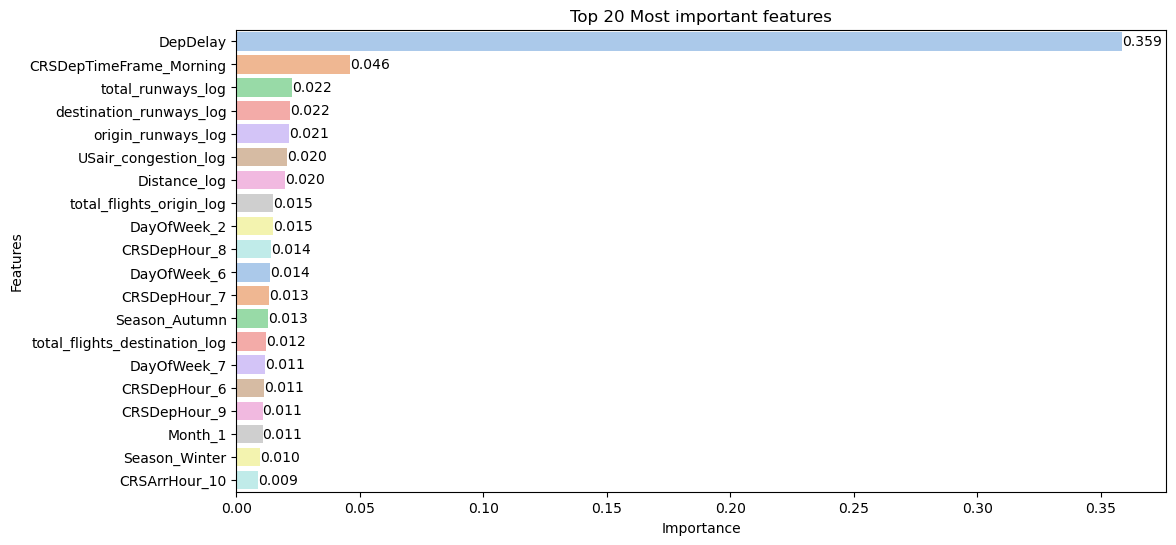

                           feature    importance
0                         DepDelay  3.586645e-01
413        CRSDepTimeFrame_Morning  4.585934e-02
4                total_runways_log  2.242237e-02
3          destination_runways_log  2.170424e-02
2               origin_runways_log  2.127027e-02
5             USair_congestion_log  2.039801e-02
1                     Distance_log  1.967832e-02
6         total_flights_origin_log  1.491304e-02
335                    DayOfWeek_2  1.485119e-02
395                   CRSDepHour_8  1.413848e-02
339                    DayOfWeek_6  1.368949e-02
394                   CRSDepHour_7  1.329968e-02
384                  Season_Autumn  1.285659e-02
7    total_flights_destination_log  1.204586e-02
340                    DayOfWeek_7  1.148628e-02
393                   CRSDepHour_6  1.108727e-02
396                   CRSDepHour_9  1.060395e-02
372                        Month_1  1.060299e-02
387                  Season_Winter  9.698059e-03
425                 

In [82]:
# Load the model from the file
grid_rf = joblib.load('random_forest_model_depdelay.pkl')


importances = grid_rf.best_estimator_.feature_importances_ #stores each features importance
feature_names = X_train.columns

feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})#dataframe creation
feature_importances.sort_values(by='importance', ascending=False, inplace=True)#sorting
top_20_features = feature_importances.head(20)#top20 importances in a series

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='importance', y='feature', data=top_20_features, orient='h', palette="pastel") #barplot + horizontal orientation

for p in barplot.patches: # looping over each bar
    width = p.get_width()  # get bar length
    barplot.text(width,       # 1 unit right of the bar
                p.get_y() + p.get_height() / 2, 
                '{:1.3f}'.format(width), 
                ha = 'left',   #setting the alignments
                va = 'center') 

plt.title('Top 20 Most important features')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

print(feature_importances)

# AdaBoost
---

In [83]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialize a DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=1, random_state=42)

# Initialize AdaBoost
ada = AdaBoostClassifier(base_estimator=dt)

param_grid = {
    'n_estimators': [50, 100,150],
    'learning_rate': [0.1, 0.5, 1],                 #Setting the parameters for adaboost. Have to be conscious of computational power required here.
    'base_estimator__max_depth': [1, 2]
}

grid_ada = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_ada.fit(X_train, y_train)

print("Best Params:",grid_ada.best_params_, "\nBest Score:",grid_ada.best_score_, "\nBest Estimator:",grid_ada.best_estimator_)

#Using best params grid model on test data
y_pred = grid_ada.predict(X_test)

# Save the model for later use.
joblib.dump(grid_ada, 'adaboost_model_depdelay.pkl')

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

metrics = {"----Test Set----\nAccuracy: ":accuracy, "Precision: ":precision, "Recall: ":recall, "F1-Score: ":f1}

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}, {metric_value:.3f}")
print(classification_report(y_test, y_pred))

Best Params: {'base_estimator__max_depth': 1, 'learning_rate': 1, 'n_estimators': 50} 
Best Score: 0.6482184413300927 
Best Estimator: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         random_state=42),
                   learning_rate=1)
----Test Set----
Accuracy: , 0.606
Precision: , 0.606
Recall: , 0.606
F1-Score: , 0.606
                     precision    recall  f1-score   support

Excessively delayed       0.74      0.60      0.66        62
 Moderately delayed       0.58      0.55      0.56       136
            On-time       0.79      0.66      0.72       496
   Slightly delayed       0.35      0.52      0.42       213

           accuracy                           0.61       907
          macro avg       0.62      0.58      0.59       907
       weighted avg       0.65      0.61      0.62       907



# Gradient Boost
---

In [84]:
# Initialize GradientBoostingClassifier
gb = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [1, 2, 3]
}

grid_gb = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_gb.fit(X_train, y_train)

print("Best Params:",grid_gb.best_params_, "\nBest Score:",grid_gb.best_score_, "\nBest Estimator:",grid_gb.best_estimator_)

#Using best params grid model on test data
y_pred = grid_gb.predict(X_test)

# Save the model for later use.
joblib.dump(grid_gb, 'gradient_boosting_model_depdelay.pkl')

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

metrics = {"----Test Set----\nAccuracy: ":accuracy, "Precision: ":precision, "Recall: ":recall, "F1-Score: ":f1}

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}, {metric_value:.3f}")

print(classification_report(y_test, y_pred))


Best Params: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 150} 
Best Score: 0.7855853067654277 
Best Estimator: GradientBoostingClassifier(learning_rate=0.5, n_estimators=150)
----Test Set----
Accuracy: , 0.677
Precision: , 0.677
Recall: , 0.677
F1-Score: , 0.677
                     precision    recall  f1-score   support

Excessively delayed       0.84      0.84      0.84        62
 Moderately delayed       0.63      0.56      0.59       136
            On-time       0.75      0.81      0.78       496
   Slightly delayed       0.43      0.38      0.41       213

           accuracy                           0.68       907
          macro avg       0.66      0.65      0.66       907
       weighted avg       0.67      0.68      0.67       907



# PROJECT SUMMARY 
---

Throughout the course of this project, 5 machine learning models were employed to predict flight delay categories. Each ML model had a version where "DepDelay" feature was not used, and a version where it was used as a feature.

These models were:
- K-Nearest Neighbors
- Logistic Regression
- Random Forests
- AdaBoost
- Gradient Boosting

K-Nearest neighbors was not very effective in this classification task. When not including Departure Delay as a feature, the accuracy score was 0.36, whilst with this additional feature accuracy rose to 0.45. The accuracy metric measures proportion of total predictions that were correctly predicted. For both models, the Grid Search algorithm found that the optimal number of neighbors was 1, which in return produced a significantly higher accuracy score on the training data, but very poor results on the test data. This is likely because when the number of neighbors is 1, the data is overfit, and therefore would not generalise well to unseen data.

Adding departure delay to the Logistic regression model saw a rise in accuracy score from 0.47 to 0.68 on the test data. The metric "recall",(for "Excessively Delayed") which measures the proportion of the actual positive class that actually got predicted as positive rose from 0.28 to 0.82, a huge increase of 0.54. This indicates that the model was a lot better at identifying the "Excessively Delayed" class. This is significant because this is one of the classes that was imbalanced in the test data, so a good score here is very useful.

Random Forest models performed adequately in both model scenarios, with test score accuracy rising from 47.6 to 63.7; a jump of 16.1. Once again, the recall class rose significantly, from a very poor 0.19 to 0.89. This is likely due to to the strong correlation between departure and arrival delays.

The inclusion of 'DepDelay'  improved the performance of AdaBoost as well, with the accuracy improving from 0.43 to 0.61. The recall for the 'Excessively delayed' class improved from 0.13 without 'DepDelay' to 0.60 with 'DepDelay'. With departure delay included, the F1 score increased from 0.433 to 0.606, whioh represents a decent "all-round" model as the f1 score is the harmonic mean between precision and recall.

The Gradient Boosting algorithm showed the most improvement once Departure Delay was added as a feature, with accuracy rising from 0.46 to 0.68. The excessively delayed flights saw a high recall score of 0.84, as well as an F1 score of 0.84.

In summary, the addition of the "DepDelay" feature led to a significant improvement in all of the models performance metrics. Notably, the precision, recall and f1 score all saw improvements in the minority classes, which addressed the issue of imbalanced classes in the dataset.



## Real Life Applications

#### Without "DepDelay"
- Although predicting delayed and excessively delayed flights is useful to airline companies, it is clearly difficult without using departure delays as a feature. 
- When looking at the classification report, this model was effective at predicting on time flights with a precision of 0.61, a recall of 0.68 and f1 score of 0.64.
- In reality, the vast majority of flights are on time or slightly delayed, so the random forest model (without "DepDelay") definitely has its uses.
- For example, by knowing a flight is going to be on time, airlines can make the necessary logistical and scheduling changes, everything runs as smoothly as possible. Passengers can also plan their schedules knowing their flight is less likely to be delayed, which is particualry important if they have important meetings/events to attend, or they have immediate connecting flights that they cannot miss. Package companies can also use this info to coordinate with travel agencies and insurance companies to produce the most cost effective holiday packages.

#### With "DepDelay"
- Regarding the model which includes departure delay as a variable, all models performed predictably better than the former set of models.
- The F1 score for 'Excessively Delayed' is 0.92, 'Moderately delayed' is 0.83, 'On-time' is 0.86, and 'Slightly delayed' is 0.77. 
- In terms of real life application, if airlines know a flight is excessively delayed, airlines can manages these flights by organising backup connection flights, quickly offer apologies to customers + potentially offer discounts/rewards to make up for aby issues caused by delays. This can help an airline preserve their band, which is of upmost importance
-Passengers can understand just how late their flight is going to be in real time. Knowing a flight is "on-time" can provide passengers with peace of mind, and make them more likely to fly with the same airline again.
- Airports will be able to take advantage of the increased precision and recall to organise their resources more effectively. For example, they can anticipate the late flights and change gate orders, locations, baggage handlers to try and lessen the prediccted potential delay.


## Future Model Development
- If possible, both sets of models could be enhanced by the addition of weather data. This would be a monumental task in terms of data sourcing and collection, but if weather conditions at each ORIGIN airport at time of takeoff could be accounted for, the models would enhance their ability to predict arrival delay.
- If more computational power was available, Grid Search could be deployed more extensively to further optimise potential models. These models were all built on a subset of 5000 flights, and the computation time was multiple hours. If more computational resources were available, better results could have been achieved.
- If other models already exist, they could be blended with this model in order ot achieve an optimal result.